<img src="https://swan.web.cern.ch/sites/swan.web.cern.ch/files/pictures/logo_swan_letters.png" alt="SWAN" style="float: left; width: 20%; margin-right: 15%; margin-left: 15%; margin-bottom: 2.0em;">
<img src="https://spark.apache.org/images/spark-logo-trademark.png" alt="EP-SFT" style="float: left; width: 25%; margin-right: 15%; margin-bottom: 2.0em;">
<p style="clear: both;">
<div style="text-align:center"><h1>Integration of SWAN with Spark clusters</h1></div>
<hr style="border-top-width: 4px; border-top-color: #34609b;">

The current setup allows to execute PySpark operations on CERN Hadoop and Spark clusters. 

This notebook illustrates the use of __Spark in SWAN to analyze the monitoring data available on HDFS (analytix)__ and plots a heatmap of loadAvg across machines in a particular service.

### Connect to the cluster (analytix)
*Env - LCG_97a & analytix*

To connect to a cluster, click on the star button on the top and follow the instructions
* The star button only appears if you have selected a SPARK cluster in the configuration
* The star button is active after the notebook kernel is ready

### Import necessary spark and python stuff

In [1]:
from pyspark.sql.functions import from_unixtime, when, col
from pyspark.sql.types import *
from pyspark.sql.functions import from_json

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### select the data
*path_on_hdfs_to_your_data*

In [3]:
df = spark.read.parquet("/project/monitoring/collectd/load/2020/10/14/")

### check the structure

In [4]:
df.printSchema()

root
 |-- dstype: string (nullable = true)
 |-- host: string (nullable = true)
 |-- interval: double (nullable = true)
 |-- plugin: string (nullable = true)
 |-- plugin_instance: string (nullable = true)
 |-- time: long (nullable = true)
 |-- type: string (nullable = true)
 |-- type_instance: string (nullable = true)
 |-- env: string (nullable = true)
 |-- region: string (nullable = true)
 |-- dc: string (nullable = true)
 |-- value: double (nullable = true)
 |-- value_instance: string (nullable = true)
 |-- _id: string (nullable = true)
 |-- availability_zone: string (nullable = true)
 |-- event_timestamp: long (nullable = true)
 |-- submitter_environment: string (nullable = true)
 |-- submitter_hostgroup: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- toplevel_hostgroup: string (nullable = true)
 |-- version: string (nullable = true)



### Create temporary table view

In [5]:
df.createOrReplaceTempView("loadAvg")

### Do the heavylifting in spark and collect aggregated view to panda DF

In [6]:
df_loadAvg_pandas = spark.sql("SELECT host, \
                                      avg(value) as avg, \
                                      hour(from_unixtime(timestamp / 1000, 'yyyy-MM-dd HH:mm:ss')) as hr \
                               FROM loadAvg \
                               WHERE submitter_hostgroup like 'hadoop_ng/nxcals_prod%' \
                               AND dayofmonth(from_unixtime(timestamp / 1000, 'yyyy-MM-dd HH:mm:ss')) = 14 \
                               GROUP BY hour(from_unixtime(timestamp / 1000, 'yyyy-MM-dd HH:mm:ss')), host")\
                    .toPandas()

### Visualize with seaborn

Text(0.5, 1, 'Heatmap of loadAvg for NXCals cluster on 14th October 2020')

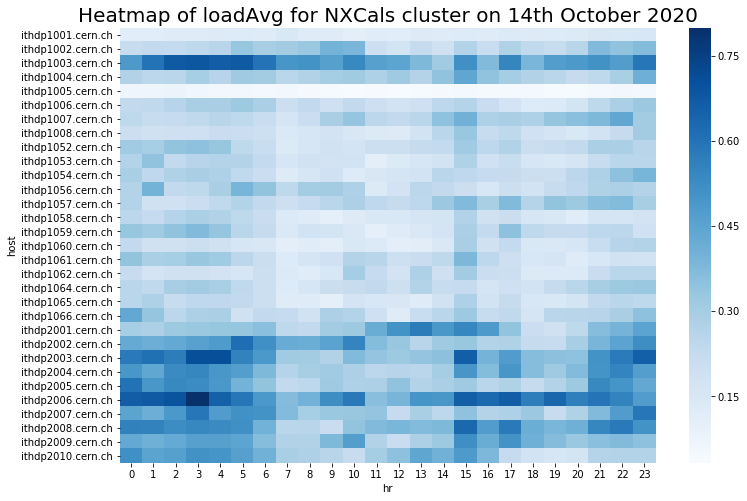

In [12]:
# heatmap of loadAvg
plt.figure(figsize=(12, 8))
ax = sns.heatmap(df_loadAvg_pandas.pivot(index='host', columns='hr', values='avg'), cmap="Blues")
ax.set_title("Heatmap of loadAvg for NXCals cluster on 14th October 2020", fontsize=20)

### Create histogram of uptime for the servers in datacenter

In [13]:
# create the dataframe
df = spark.read.parquet("/project/monitoring/collectd/uptime/2020/10/14/")

In [14]:
# create temporary view
df.createOrReplaceTempView("uptime")

In [15]:
# processing in spark
df_uptime_pandas = spark.sql("SELECT  host, round(max(value)/60/60/24) as days \
                              FROM uptime \
                               WHERE dayofmonth(from_unixtime(timestamp / 1000, 'yyyy-MM-dd HH:mm:ss')) = 14 \
                               AND hour(from_unixtime(timestamp / 1000, 'yyyy-MM-dd HH:mm:ss')) = 12 \
                               GROUP BY host")\
                    .toPandas()

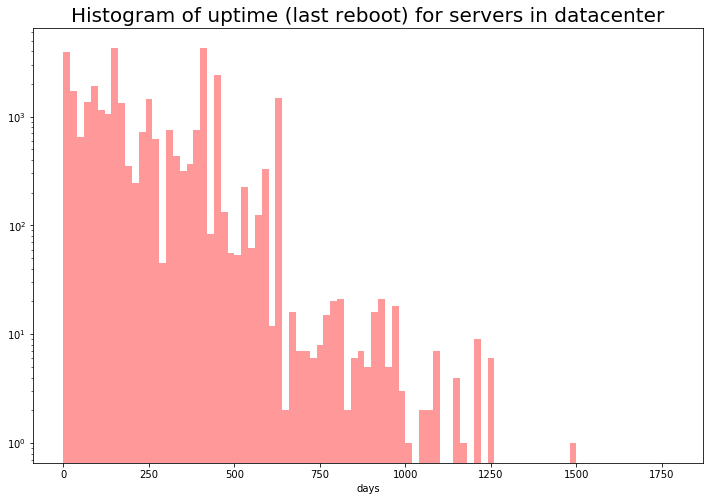

In [16]:
# visualize with seaborn
# histogram of uptime (last reboot)
plt.figure(figsize=(12, 8))
ax = sns.distplot(df_uptime_pandas['days'], kde=False, color='red', bins=range(0, 1800, 20))
ax.set_title("Histogram of uptime (last reboot) for servers in datacenter", fontsize=20)
ax.set_yscale('log')